## Example Workbook For Creating Propeller CHARM Input Files from OpenVSP
This workbook is designed to be a simple example of how to generate input files for CHARM from an OpenVSP file using Uber developed python helper packages

### Import packages
The first step in using the utilties is to import the distributed packages as well as any other packages needed to manipulate the case setup

In [1]:
# Import the helper packages
import charm.input_automation as charm
import openvsp as vsp
import utilities.units as u

# Import standard useful python packages
import os
import math

### Define Case Specific Constants
Next we will define some constants for the specifics of this example case

In [2]:
# directory definitions
base_directory = "simple_config"
template_directory = "templates"
geom_directory = "geom"
run_directory = "runs"

overwrite_files = True

# vsp specifics
vsp_filename = "simple_config_large.vsp3"
vsp_charm_set_name = "CHARM"
vsp_pitch_comp_name = "Datum" # Name of the VSP component to rotate in order to change vehicle pitch
vsp_lift_prop_name = "HoverProps" # Lift propeller name
vsp_cruise_prop_name = "CruiseProp" # Cruise propeller name
vsp_vert_tail_name = "VertTail"
vsp_horz_tail_name = "HTail"

# charm template files
charm_prop_rw_template = "proprw.inp" # rotor wake template file
charm_wing_rw_template = "rmwingrw.inp" # wing rotor wake template file
charm_rc_template = "simple_config.inp" # run characteristics file
charm_casename = "simple_config" # name of the charm case

# Solution Specifics
airspeed_fts = 100.0 * u.mph2fts # Airspeed in feet per second
pitch_deg = 0.0 # 0.0 air along x axis, 90.0 vertical climb
alpha_deg = 0.0 # angle of attack degs
lift_prop_collective = 20.0 # collective on lift propellers (degs)
lift_prop_rpm = 1444.0 # rpm on lift propellers
lift_prop_ct = 0.01206 # lift propeller target ct
cruise_prop_collective = 0.0 # propeller collective
cruise_prop_rpm = 1444.0 # propeller RPM
cruise_prop_ct = 0.004827 # cruise propeller target ct

### Import OpenVSP Geometry & Plot

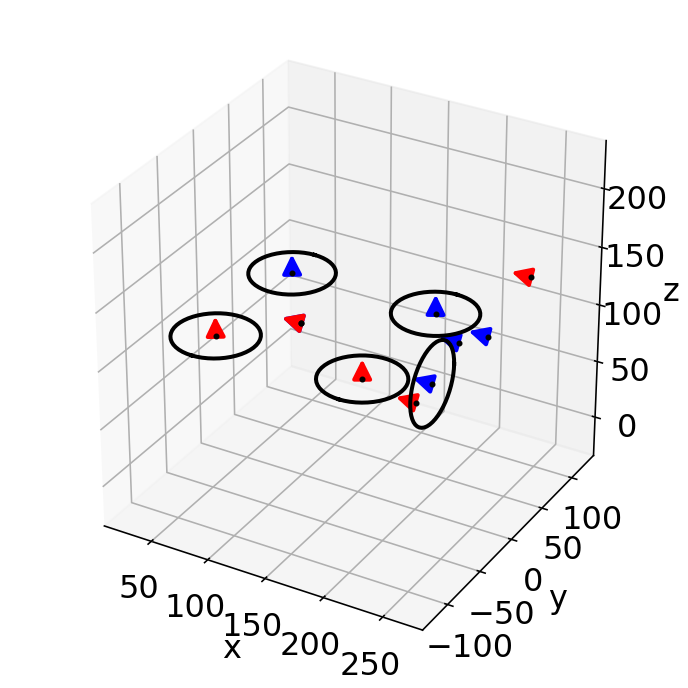

In [3]:
# Reset VSP's state
vsp.VSPRenew()
vsp.ClearVSPModel()
vsp.DeleteAllResults()

# Load in the vsp model
vsp.ReadVSPFile(os.path.join(base_directory, geom_directory, vsp_filename))

# Get the geom ids of specific vsp components
vsp_pitch_compid = vsp.FindGeom(vsp_pitch_comp_name, 0)
vsp_lift_propid = vsp.FindGeom(vsp_lift_prop_name, 0)
vsp_cruise_propid = vsp.FindGeom(vsp_cruise_prop_name, 0)
vsp_vert_tailid = vsp.FindGeom(vsp_vert_tail_name, 0)
vsp_horz_tailid = vsp.FindGeom(vsp_horz_tail_name, 0)

# Apply the tilt angle in vsp
vsp.SetParmVal(vsp_pitch_compid, "Y_Rel_Rotation", "XForm", pitch_deg)

# Update the vsp model
vsp.Update()

# Run degen geom and plot
vsp_charm_set_index = vsp.GetSetIndex(vsp_charm_set_name)
dg_mgr = vsp.run_degen_geom(set_name=vsp_charm_set_name)
prop_info = vsp.get_propeller_thrust_vectors(prop_set=vsp_charm_set_index)

# Plot propellers
prop_fig = vsp.plot_propeller_info(prop_info, vector_scale=20)

### Create inputs for charm
Now that the geometry has been loaded, and the we have verified its position, we can now generate the charm input files

In [4]:
# Clear out old vsp results
vsp.DeleteAllResults()

# Run degen geom on the charm set
degen_mgr = vsp.run_degen_geom(set_index=vsp_charm_set_index)

# Read in template file
rotor_rw = []
with open(os.path.join(base_directory, template_directory, charm_prop_rw_template), "r") as f:
    rotor_rw = f.readlines()


# Initialize the rotor settings object
rotor_settings = charm.build_default_rotor_settings(degen_mgr=degen_mgr, default_rpm=lift_prop_rpm,
                                                    default_template=rotor_rw)

# Set CHARM lift rotor settings
rotor_settings[vsp_lift_propid].icoll = 0
rotor_settings[vsp_lift_propid].initial_collective = lift_prop_collective
rotor_settings[vsp_lift_propid].rpm = lift_prop_rpm
rotor_settings[vsp_lift_propid].ct = lift_prop_ct

# Set CHARM cruise propeller settings
rotor_settings[vsp_cruise_propid].icoll = 0
rotor_settings[vsp_cruise_propid].initial_collective = cruise_prop_collective
rotor_settings[vsp_cruise_propid].rpm = cruise_prop_rpm
rotor_settings[vsp_cruise_propid].ct = cruise_prop_ct

# Setup wing like inputs
wing_rw = []
with open(os.path.join(base_directory, template_directory, charm_wing_rw_template), "r") as f:
    wing_rw = f.readlines()

wing_settings = charm.build_default_wing_settings(degen_mgr=degen_mgr, default_template=wing_rw)

# Reduced resolution on vertical & horizontal tail
wing_settings[vsp_vert_tailid].nspan_override = 20
wing_settings[vsp_horz_tailid].nspan_override = 20

# Create velocity vector
u_speed = airspeed_fts*math.cos(alpha_deg * u.deg2rad)
v = 0.0
w = airspeed_fts*math.sin(alpha_deg * u.deg2rad)

# Create input file list
files_to_write = charm.build_charm_input_files(degen_mgr=degen_mgr, case_name=charm_casename,
                                              rotor_settings=rotor_settings,
                                              wing_settings=wing_settings,
                                              unit_factor=u.in2ft,
                                              run_char_filename=os.path.join(base_directory,
                                                                             template_directory,charm_rc_template),
                                              velocity=[u_speed, v, w])


run_dir_name = 'run_v{:.3}_pitch_{:3.2f}_alpha_{:3.2f}'.format(airspeed_fts, pitch_deg, alpha_deg)

### Write out the files
Now that the files have been generate and are currently stored in memory, we can write them out a directory where we can execute charm

In [5]:
cwd = os.getcwd()
try:
    charm_exe_dir = os.path.join(base_directory, run_directory, run_dir_name)
    os.makedirs(charm_exe_dir, exist_ok=overwrite_files)
    os.chdir(charm_exe_dir)
    
    for filename, file_contents in files_to_write.items():
        with open(filename, 'w') as f:
            f.write(file_contents)
finally:
    os.chdir(cwd)

### Next Steps
Now that the charm input files have been generated, you can go to the output directory and start running CHARM.